# Building Taxi Fare Prediction using SageMaker 

<p>This demo notebook guides through the steps in creating an AWS Sagemaker predictions service</p>
<p>To start using Sagemaker go here: <a href="https://aws.amazon.com/sagemaker/">Sagemaker</a></p>

In [1]:
import pandas as pd
import os
from s3fs.core import S3FileSystem
import random

import shap

import boto3
from botocore.client import Config
import json

In [2]:
from sagemaker import get_execution_role

role = get_execution_role()
print(role)

arn:aws:iam::282784146513:role/service-role/AmazonSageMaker-ExecutionRole-20190604T113688


## Read the whole data from S3

In [3]:
S3FileSystem.read_timeout = 3600

In [4]:
s3 = S3FileSystem(anon=False)
bucket = 'aws-worskhop-data/ZIPCHUNKS'
file_list = s3.ls(bucket)
subs = 'ZIPCHUNKS'
res = [i for i in file_list if subs in i] 

In [5]:
# we remove the folder ZIPCHUNKS if it exists (so later we can merge the files in loop)
if 'aws-worskhop-data/ZIPCHUNKS' in res: res.remove('aws-worskhop-data/ZIPCHUNKS')

In [6]:
res

['aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSaa',
 'aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSab',
 'aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSac',
 'aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSad',
 'aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSae',
 'aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSaf',
 'aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSag',
 'aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSah',
 'aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSai',
 'aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSaj',
 'aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSak',
 'aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSal',
 'aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSam',
 'aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSan',
 'aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSao',
 'aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSap',
 'aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSaq']

In [7]:
#res = res[0::5]

In [8]:
jj = 0

for filechunk in res:
        print (filechunk)
        if jj == 0:
            with s3.open('aws-worskhop-data/taxinyc_train.csv.zip', 'wb') as f:
                f.write(s3.cat(filechunk))
                jj = jj + 1        
                f.close()
        else:
            with s3.open('aws-worskhop-data/taxinyc_train.csv.zip', 'ab') as f:
                f.write(s3.cat(filechunk))
                jj = jj + 1
                f.close()

aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSaa
aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSab
aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSac
aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSad
aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSae
aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSaf
aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSag
aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSah
aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSai
aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSaj
aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSak
aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSal
aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSam
aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSan
aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSao
aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSap
aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSaq


In [9]:
bucket = 'aws-worskhop-data'
path = ''

filename = 'taxinyc_train.csv.zip'
s3_path = os.path.join('s3://', bucket, path, filename)

df_all = pd.read_csv(s3_path, header=0, skiprows=lambda i: i>0 and random.random() > 0.01)

In [10]:
df_all

,fare_amount,day,dayofweek,year,month,dayofmonth,hour,minute,sin_day,cos_day,...,cos_week,diff_longitude,diff_latitude,dist,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,11,6,2010,12,11,20,25,0.362438,0.932008,...,-0.922682,0.011566,0.011147,0.016063,2010-12-12 01:25:00 UTC,-73.994720,40.755060,-74.006290,40.743910,2
1,39.0,27,3,2013,3,27,17,10,-0.675590,0.737277,...,0.994391,-0.013168,-0.127422,0.128101,2013-03-27 21:10:00 UTC,-73.981460,40.666767,-73.968290,40.794190,1
2,3.3,26,6,2012,5,26,12,26,-0.917494,-0.397748,...,-0.744083,-0.006180,-0.001499,0.006359,2012-05-26 16:26:15 UTC,-73.988754,40.741120,-73.982574,40.742620,2
3,8.5,17,2,2013,12,17,4,51,0.531830,-0.846851,...,0.143791,0.014153,0.019421,0.024030,2013-12-17 09:51:29 UTC,-73.976330,40.759594,-73.990486,40.740173,1
4,8.5,15,1,2015,6,15,6,43,0.326943,-0.945044,...,-0.659970,0.023010,0.010288,0.025206,2015-06-15 10:43:40 UTC,-73.918350,40.765495,-73.941360,40.755207,3
5,9.5,3,4,2014,7,3,14,38,-0.986286,0.165048,...,0.766845,-0.025826,-0.026150,0.036753,2014-07-03 18:38:00 UTC,-73.975130,40.750640,-73.949300,40.776790,1
6,5.3,16,2,2010,3,16,9,45,-0.442289,-0.896873,...,0.285808,-0.009323,-0.008606,0.012688,2010-03-16 13:45:00 UTC,-73.972305,40.763386,-73.962980,40.771990,5
7,8.0,8,6,2014,2,8,23,22,0.909961,0.414693,...,-0.959525,-0.004814,-0.020008,0.020579,2014-02-09 04:22:00 UTC,-73.985740,40.747610,-73.980930,40.767616,3
8,22.0,1,2,2014,7,1,7,6,0.229837,-0.973229,...,0.190105,0.005646,0.055916,0.056200,2014-07-01 11:06:51 UTC,-73.955340,40.764473,-73.960980,40.708557,2
9,10.1,20,5,2009,11,20,12,41,-0.996566,-0.082808,...,0.011843,0.020851,0.022854,0.030937,2009-11-20 17:41:00 UTC,-73.966940,40.761845,-73.987790,40.738990,1


## Start Exploring the data 

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [12]:
# Sample the data - because it only take a 100K records to feel the data
df_all = df_all.sample(int(1e5))

In [13]:
df_small = df_all.sample(int(1e2))
df_small

,fare_amount,day,dayofweek,year,month,dayofmonth,hour,minute,sin_day,cos_day,...,cos_week,diff_longitude,diff_latitude,dist,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
149919,9.5,20,4,2014,11,20,15,27,-0.801254,0.598325,...,0.721501,0.020927,0.009232,0.022873,2014-11-20 20:27:00 UTC,-73.954070,40.774475,-73.975000,40.765244,1
305656,17.7,6,6,2010,3,6,21,49,0.673926,0.738799,...,-0.941698,-0.048210,-0.049316,0.068966,2010-03-07 02:49:29 UTC,-74.004830,40.721340,-73.956620,40.770657,1
111598,12.5,29,5,2013,3,29,21,19,0.339627,0.940560,...,-0.270490,-0.029999,-0.047199,0.055926,2013-03-30 01:19:25 UTC,-73.986664,40.719710,-73.956665,40.766910,1
161306,13.7,16,4,2012,2,16,19,38,0.165048,0.986286,...,0.604798,0.022804,0.037670,0.044035,2012-02-17 00:38:00 UTC,-73.960110,40.710854,-73.982920,40.673183,1
43642,4.0,18,3,2014,6,18,20,28,0.121869,0.992546,...,0.999848,0.001083,-0.000072,0.001086,2014-06-19 00:28:00 UTC,-73.993576,40.749820,-73.994660,40.749893,1
46146,5.0,16,4,2013,5,16,3,31,0.920675,-0.390329,...,0.960589,0.013512,-0.004723,0.014313,2013-05-16 07:31:54 UTC,-73.987640,40.724720,-74.001150,40.729443,2
101122,8.1,11,6,2012,2,11,19,42,0.182236,0.983255,...,-0.912018,-0.000420,-0.009911,0.009919,2012-02-12 00:42:00 UTC,-73.989296,40.718980,-73.988880,40.728890,1
33876,14.5,1,6,2012,12,1,15,27,-0.798985,0.601350,...,-0.835899,0.026131,0.027084,0.037635,2012-12-01 20:27:52 UTC,-73.955790,40.773453,-73.981920,40.746370,4
409342,16.0,3,3,2015,6,3,3,18,0.942155,-0.335178,...,0.811331,0.038338,0.033379,0.050832,2015-06-03 07:18:20 UTC,-73.971190,40.746140,-74.009530,40.712760,1
542857,16.9,26,4,2012,7,26,18,16,-0.438371,0.898794,...,0.672828,0.045166,0.052887,0.069549,2012-07-26 22:16:00 UTC,-73.958565,40.768800,-74.003730,40.715910,1


In [14]:
df_all.describe()

,fare_amount,day,dayofweek,year,month,dayofmonth,hour,minute,sin_day,cos_day,sin_week,cos_week,diff_longitude,diff_latitude,dist,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,99999.000000,99999.000000,99999.000000,100000.000000,100000.000000,99999.000000,99999.000000,100000.000000
mean,11.292492,15.763290,3.986310,2011.746760,6.277130,15.763290,11.848270,29.613070,-0.208062,-0.040695,0.045184,0.029691,-0.004947,-0.009748,0.216171,-72.483338,39.900223,-72.478376,39.909963,1.683120
std,9.616236,8.673218,1.904185,1.860592,3.431479,8.673218,5.821238,17.316561,0.650706,0.729140,0.712395,0.699700,6.846217,2.106269,7.159640,12.068971,6.159322,10.519863,6.267632,1.305452
min,-19.300000,1.000000,1.000000,2008.000000,1.000000,1.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1915.618200,-394.127660,0.000000,-1915.618200,-74.008965,-121.914810,-74.014230,0.000000
25%,6.000000,8.000000,2.000000,2010.000000,3.000000,8.000000,7.000000,15.000000,-0.819152,-0.774393,-0.715682,-0.665506,-0.013672,-0.014084,0.012334,-73.992060,40.735010,-73.991360,40.734287,1.000000
50%,8.500000,16.000000,4.000000,2012.000000,6.000000,16.000000,12.000000,30.000000,-0.342362,-0.100188,0.033612,0.080323,-0.000458,0.000000,0.021416,-73.981710,40.752700,-73.980030,40.753338,1.000000
75%,12.500000,23.000000,6.000000,2013.000000,9.000000,23.000000,17.000000,45.000000,0.350207,0.717620,0.720638,0.731653,0.011169,0.013643,0.038119,-73.966995,40.767080,-73.963540,40.768060,2.000000
max,300.000000,31.000000,7.000000,2015.000000,12.000000,31.000000,23.000000,59.000000,1.000000,1.000000,1.000000,1.000000,75.436450,41.034405,1915.622481,40.806458,49.516666,40.809980,434.850000,6.000000


### Date-Time Features 

In [15]:
df_all['ts'] = df_all['pickup_datetime'].apply(pd.Timestamp)
df_all['weekday'] = df_all['ts'].dt.weekday
df_all['day'] = df_all['ts'].dt.day
df_all['month'] = df_all['ts'].dt.month
df_all['year'] = df_all['ts'].dt.year
df_all['hour'] = df_all['ts'].dt.hour

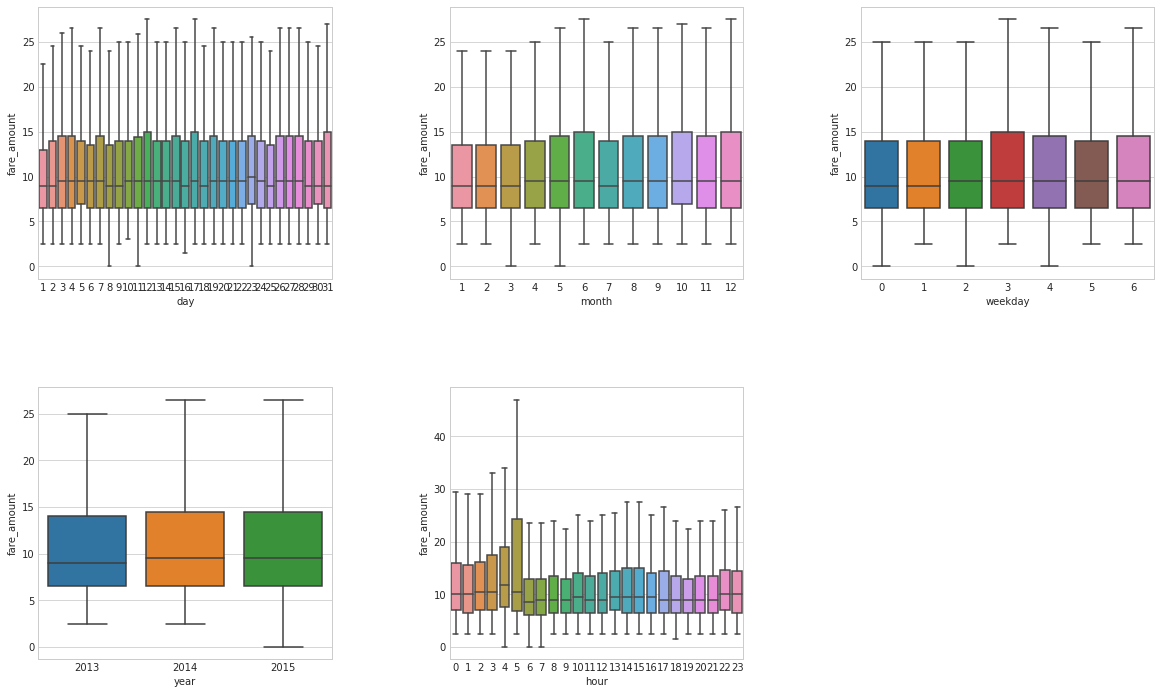

In [16]:
time_features = ['day', 'month', 'weekday', 'year', 'hour']

fig = plt.figure(figsize=(20,12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(len(time_features)):
    ax = fig.add_subplot(2, 3, i+1)
    sns.boxplot(x=time_features[i], y="fare_amount", data=df_all[df_all['year'] >= 2013], showfliers=False)

plt.show()

### Geographic 

https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration

In [17]:
nyc_box = (-74.1, -73.7, 40.6, 40.9)

In [18]:
def filter_coordinates(df, box):
    return (df.pickup_longitude >= box[0]) & (df.pickup_longitude <= box[1]) & \
           (df.pickup_latitude >= box[2]) & (df.pickup_latitude <=box[3]) & \
           (df.dropoff_longitude >= box[0]) & (df.dropoff_longitude <= box[1]) & \
           (df.dropoff_latitude >= box[2]) & (df.dropoff_latitude <= box[3])

In [19]:
def plot_hires(df, box, figsize=(12, 12), ax=None, c=sns.color_palette("husl", 2)):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    idx = filter_coordinates(df, box)
    ax.scatter(df[idx].pickup_longitude, df[idx].pickup_latitude, c=c[0], s=0.1, lw=0.1, alpha=0.5)
    ax.scatter(df[idx].dropoff_longitude, df[idx].dropoff_latitude, c=c[1], s=0.1, lw=0.1, alpha=0.5)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


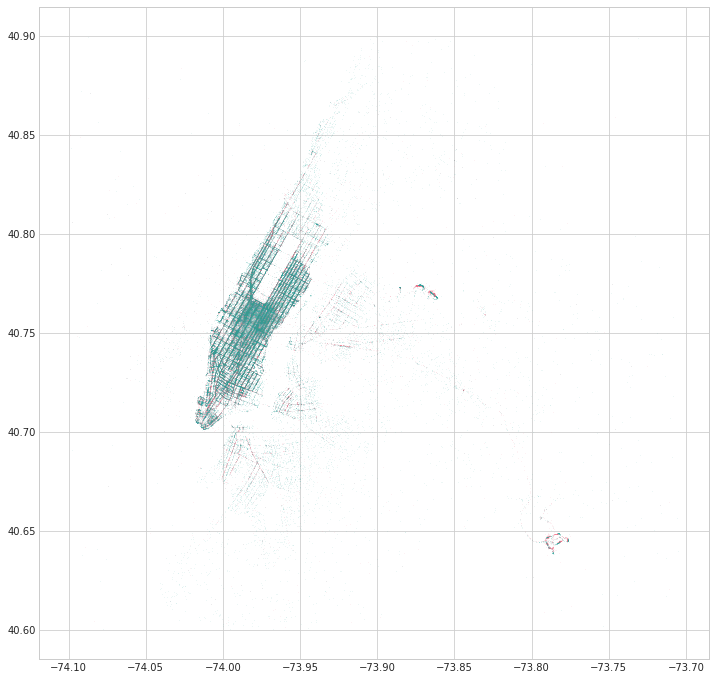

In [20]:
plot_hires(df_all, nyc_box)

<p>In the scatter plot above, the two major NYC airports are easily observed, indicating that it may be informative to "tell" our algorithm whether the ride starts or ends in an airport.</p>
<p>To do so I use the airports.csv, available <a href="http://ourairports.com/data/">here</a> in the following way:</p>
<ul>
<li>from this file I extract the location of 3 of the listed NYC airports</li>
<li>I than calculate the distance of dropoff and pickup points from every record to each airport, Assuming it will provide additional information to our model.</li>
</ul>
<p>Further details are in the feature extraction below</p>

## Ride distance 

In [21]:
df_all['air_distance'] = (df_all.pickup_longitude - df_all.dropoff_longitude)**2 +\
                     (df_all.pickup_latitude - df_all.dropoff_latitude)**2
df_all['air_distance'] = np.sqrt(df_all['air_distance'])

In [22]:
df_all['price_per_distance'] = df_all['fare_amount'] / df_all['air_distance']

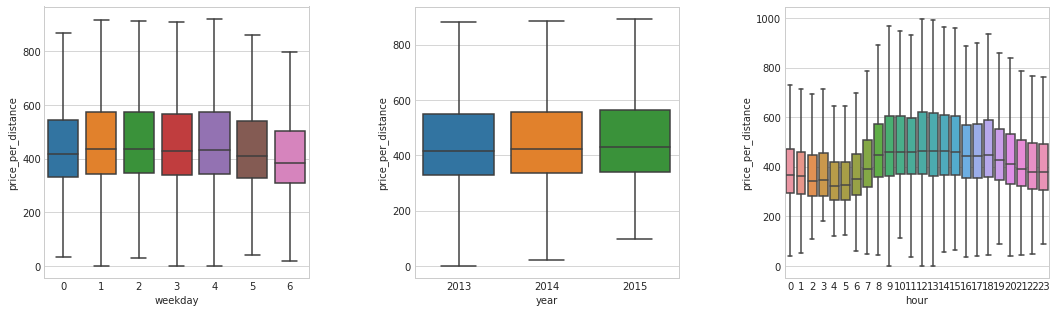

In [23]:
time_features = ['weekday', 'year', 'hour']
fig = plt.figure(figsize=(18,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(len(time_features)):
    ax = fig.add_subplot(1, 3, i+1)
    sns.boxplot(x=time_features[i], y="price_per_distance", data=df_all[df_all['year'] >= 2013], showfliers=False)

plt.show()

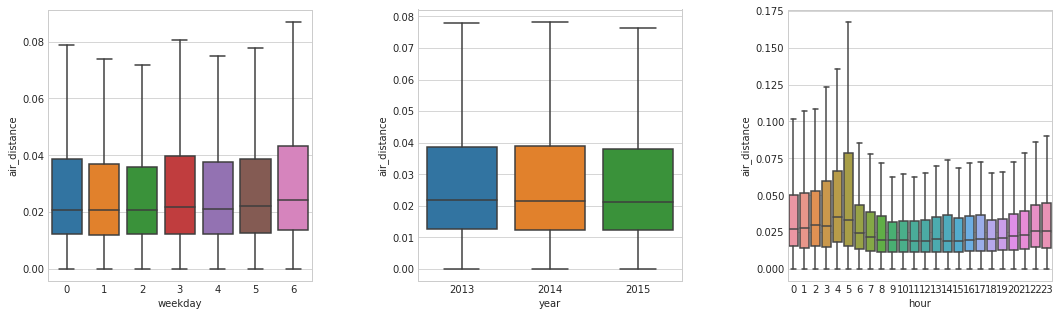

In [24]:
time_features = ['weekday', 'year', 'hour']
fig = plt.figure(figsize=(18,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(len(time_features)):
    ax = fig.add_subplot(1, 3, i+1)
    sns.boxplot(x=time_features[i], y="air_distance", data=df_all[df_all['year'] >= 2013], showfliers=False)

plt.show()

## Split train test 

<p>If you managed to create the dataset using Athena, you have two options on how to create train and validation sets files.&nbsp;</p>
<ol>
<li>Create a seperate query, using a WHERE on the year clause to split the train and validation by time (e.g. year, month)</li>
<li>Create a single query, partition the results by time, and use aws-cli to mv the directories to different train/validation directotires</li>
</ol>

## Prepare the data for training

In [25]:
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker
from sagemaker import get_execution_role
import boto3
from datetime import datetime
import os
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [26]:
bucket = 'aws-worskhop-data'
path = ''

filename_train = 'taxinyc_train.csv'
filename_validate = 'taxinyc_validation.csv' 

s3_path_2014 = os.path.join('s3://', bucket, path, filename_train)
s3_path_2015 = os.path.join('s3://', bucket, path, filename_validate)

In [27]:
df_2014 = pd.read_csv(s3_path_2014, skiprows=lambda i: i>0 and random.random() > 0.1)

#n = 10  # every 100th line = 1% of the lines
#df_2014 = pd.read_csv(s3_path_2014, header=0, skiprows=lambda i: i % n != 0)

del df_2014['pickup_datetime']
df_2014.to_csv('train_small_2014.csv', header=True, index=False)
df_2014_final = pd.read_csv('./train_small_2014.csv')
df_2014_final

,fare_amount,day,dayofweek,year,month,dayofmonth,hour,minute,sin_day,cos_day,sin_week,cos_week,diff_longitude,diff_latitude,dist,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,9.70,17,1,2011,10,17,23,4,0.720248,0.693716,-0.994009,-0.109301,-0.023087,-0.043823,0.049532,-73.993190,40.752663,-73.970100,40.796486,1
1,5.30,7,6,2012,4,7,7,28,0.139173,-0.990268,0.794112,-0.607772,0.001808,0.013706,0.013825,-73.986090,40.757504,-73.987900,40.743797,2
2,3.70,17,3,2010,3,17,8,13,-0.056693,-0.998392,-0.426569,0.904455,-0.000191,0.005512,0.005516,-73.995190,40.731598,-73.995000,40.726086,5
3,9.30,11,3,2009,11,11,22,10,0.737277,0.675590,0.118156,0.992995,-0.029396,-0.037891,0.047957,-74.003170,40.751377,-73.973770,40.789270,1
4,7.30,8,5,2012,6,8,12,13,-0.892979,-0.450098,0.997777,0.066647,0.016106,-0.010349,0.019144,-73.963940,40.765068,-73.980050,40.775417,1
5,2.50,23,7,2014,11,23,4,16,0.656059,-0.754710,0.102048,-0.994779,0.000175,0.000053,0.000183,-73.969124,40.785460,-73.969300,40.785408,3
6,48.33,9,7,2013,6,9,18,31,-0.375146,0.926966,-0.383758,-0.923434,0.130829,0.058056,0.143132,-73.885254,40.773094,-74.016080,40.715040,1
7,12.90,22,5,2011,4,22,11,52,-0.848048,-0.529919,0.996819,0.079702,0.021652,0.021671,0.030634,-73.982210,40.774765,-74.003860,40.753094,5
8,4.50,16,5,2009,1,16,18,4,-0.241922,0.970296,0.982100,-0.188361,-0.009766,0.007748,0.012466,-73.964500,40.726807,-73.954735,40.719060,1
9,7.70,2,1,2009,11,2,0,36,0.994529,0.104456,-0.611733,-0.791065,-0.006699,-0.020935,0.021981,-73.998650,40.728016,-73.991950,40.748950,1


In [28]:
df_2015 = pd.read_csv(s3_path_2015, header=0, skiprows=lambda i: i>0 and random.random() > 0.1)

#n = 10  # every 100th line = 1% of the lines
#df_2015 = pd.read_csv(s3_path_2015, header=0, skiprows=lambda i: i % n != 0)

del df_2015['pickup_datetime']
df_2015.to_csv('validate_small_2015.csv', header=True, index=False)
df_2015_final = pd.read_csv('./validate_small_2015.csv')
df_2015_final

,fare_amount,day,dayofweek,year,month,dayofmonth,hour,minute,sin_day,cos_day,sin_week,cos_week,diff_longitude,diff_latitude,dist,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,6.00,31,6,2015,1,31,16,51,-0.530906,0.847431,0.504456,-0.863437,0.014557,-0.001915,0.014682,-73.927795,40.744408,-73.942350,40.746323,1
1,19.00,31,6,2015,1,31,15,4,-0.855025,0.518587,0.560768,-0.827973,-0.040352,0.023727,0.046811,-73.996430,40.737724,-73.956080,40.713997,2
2,6.00,24,2,2015,2,24,9,11,-0.543236,-0.839580,-0.953413,0.301667,0.007416,0.009296,0.011892,-74.003750,40.732130,-74.011170,40.722830,1
3,9.00,22,3,2015,4,22,14,45,-0.980084,0.198584,-0.194591,0.980884,0.010551,-0.010441,0.014844,-73.973140,40.744300,-73.983690,40.754740,2
4,4.00,22,5,2015,5,22,2,18,0.996709,-0.081069,0.905939,0.423409,0.012344,0.001431,0.012427,-73.878310,40.748590,-73.890656,40.747158,1
5,11.50,22,7,2015,3,22,13,38,-0.995691,-0.092733,-0.209568,-0.977794,-0.023453,-0.029629,0.037787,-74.004930,40.706867,-73.981476,40.736496,1
6,19.00,22,3,2015,4,22,19,49,-0.046380,0.998924,-0.006628,0.999978,-0.057701,-0.066631,0.088143,-73.981590,40.741040,-73.923890,40.807670,1
7,45.00,13,5,2015,3,13,21,5,0.281365,0.959601,0.965055,-0.262049,0.182549,-0.062897,0.193080,-73.783950,40.648632,-73.966500,40.711530,1
8,8.00,2,1,2015,3,2,10,8,-0.733829,-0.679335,-0.849641,-0.527362,-0.014557,-0.014610,0.020624,-73.979120,40.753456,-73.964560,40.768066,1
9,9.50,4,7,2015,1,4,14,52,-0.881063,0.472999,-0.290533,-0.956865,-0.004547,-0.015751,0.016394,-73.985270,40.748440,-73.980720,40.764190,3


In [29]:
!aws s3 cp train_small_2014.csv s3://aws-worskhop-data/taxinyc-query-results/train2/train_small_2014.csv

upload: ./train_small_2014.csv to s3://aws-worskhop-data/taxinyc-query-results/train2/train_small_2014.csv


In [30]:
!aws s3 cp validate_small_2015.csv s3://aws-worskhop-data/taxinyc-query-results/validate2/validate_small_2015.csv

upload: ./validate_small_2015.csv to s3://aws-worskhop-data/taxinyc-query-results/validate2/validate_small_2015.csv


In [31]:
container = get_image_uri(boto3.Session().region_name, 'xgboost', repo_version="0.90-2")

In [32]:
s3_input_train = boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join('train_small_2014.csv')).upload_file('train_small_2014.csv')
s3_input_validation = boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join('validate_small_2015.csv')).upload_file('validate_small_2015.csv')

In [33]:
s3_input_train  = sagemaker.s3_input(s3_data='s3://{}/{}'.format(bucket, 'train_small_2014.csv'),
                                            content_type='csv')

s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}'.format(bucket, 'validate_small_2015.csv'),
                                         content_type='csv')

In [34]:
sess = sagemaker.Session()
role = get_execution_role()

## Train and debug the model 

In [35]:
from smdebug.trials import create_trial
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig, CollectionConfig

In [36]:
training_job_path = os.path.join('training_jobs', datetime.now().strftime('%Y-%m-%d-%H-%M-%S'))

In [37]:
hyperparameters = {
    "max_depth": "9",
    "eta": "0.2",
    "gamma": "4",
    "min_child_weight": "300",
    "subsample": "0.8",
    "silent": "0",
    "objective": "reg:linear",
    "early_stopping_rounds": "10",
    "tree_method": "exact",
    "num_round": "30"
}

save_interval = 5

In [38]:
feature_names = list(df_small.columns[1:])
feature_names

['day',
 'dayofweek',
 'year',
 'month',
 'dayofmonth',
 'hour',
 'minute',
 'sin_day',
 'cos_day',
 'sin_week',
 'cos_week',
 'diff_longitude',
 'diff_latitude',
 'dist',
 'pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count']

In [39]:
hyperparameters_constrained = hyperparameters.copy()
hyperparameters_constrained['monotone_constraints'] = "(0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0)"

In [40]:
!pip freeze

absl-py==0.9.0
alabaster==0.7.10
anaconda-client==1.6.14
anaconda-project==0.8.2
asn1crypto==0.24.0
astor==0.8.1
astroid==1.6.3
astropy==3.0.2
attrs==18.1.0
Automat==0.3.0
autovizwidget==0.15.0
awscli==1.18.39
Babel==2.5.3
backcall==0.1.0
backports.shutil-get-terminal-size==1.0.0
bcrypt==3.1.7
beautifulsoup4==4.6.0
bitarray==0.8.1
bkcharts==0.2
blaze==0.11.3
bleach==2.1.3
bokeh==1.4.0
boto==2.48.0
boto3==1.12.39
botocore==1.15.39
Bottleneck==1.2.1
cached-property==1.5.1
certifi==2019.11.28
cffi==1.11.5
characteristic==14.3.0
chardet==3.0.4
click==6.7
cloudpickle==0.5.3
clyent==1.2.2
colorama==0.3.9
contextlib2==0.5.5
cryptography==2.9
cycler==0.10.0
Cython==0.28.4
cytoolz==0.9.0.1
dask==1.2.2
datashape==0.5.4
decorator==4.3.0
defusedxml==0.6.0
distributed==1.28.1
docker==4.2.0
docker-compose==1.25.5
dockerpty==0.4.1
docopt==0.6.2
docutils==0.14
entrypoints==0.2.3
enum34==1.1.9
environment-kernels==1.1.1
et-xmlfile==1.0.1
fastcache==1.0.2
filelock==3.0.4
Flask==1.0.2
Flask-Cors==3.0.4
g

In [41]:
xgboost_estimator = sagemaker.estimator.Estimator(
    role=role,
    train_instance_count=1,
    train_instance_type='ml.m5.4xlarge',
    output_path='s3://{}/{}/output'.format(bucket,training_job_path),
    image_name=container,
    hyperparameters=hyperparameters,
    train_max_run=10800,
    sagemaker_session=sess,

    debugger_hook_config=DebuggerHookConfig(
        s3_output_path='s3://{}/{}/output'.format(bucket,training_job_path),  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="feature_importance",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="full_shap",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="average_shap",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
        ],
    ),

    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": str(save_interval * 2),
            },
        ),
    ],
)

In [42]:
's3://{}/{}/output'.format(bucket,training_job_path)

's3://aws-worskhop-data/training_jobs/2020-06-21-13-27-52/output'

In [43]:
xgboost_estimator.fit({'train': s3_input_train, 'validation': s3_input_validation})

2020-06-21 13:27:53 Starting - Starting the training job...
2020-06-21 13:27:55 Starting - Launching requested ML instances
********* Debugger Rule Status *********
*
*  LossNotDecreasing: InProgress        
*
****************************************
......
2020-06-21 13:29:02 Starting - Preparing the instances for training...
2020-06-21 13:29:47 Downloading - Downloading input data
2020-06-21 13:29:47 Training - Downloading the training image...
2020-06-21 13:30:21 Training - Training image download completed. Training in progress.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter tree_method value exact to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in

In [44]:
xgboost_estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:eu-west-1:282784146513:processing-job/sagemaker-xgboost-2020-06--lossnotdecreasing-4ac29dc8',
  'RuleEvaluationStatus': 'InProgress',
  'LastModifiedTime': datetime.datetime(2020, 6, 21, 13, 43, 13, 351000, tzinfo=tzlocal())}]

In [45]:
xgboost_estimator.latest_job_debugger_artifacts_path()

's3://aws-worskhop-data/training_jobs/2020-06-21-13-27-52/output/sagemaker-xgboost-2020-06-21-13-27-53-616/debug-output'

In [46]:
s3_output_path = xgboost_estimator.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2020-06-21 13:43:14.117 ip-172-16-77-40:30488 INFO s3_trial.py:42] Loading trial debug-output at path s3://aws-worskhop-data/training_jobs/2020-06-21-13-27-52/output/sagemaker-xgboost-2020-06-21-13-27-53-616/debug-output


In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import re


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

def plot_collection(trial, collection_name, regex='.*', figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and 
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.despine()

    tensors = trial.collection(collection_name).tensor_names

    for tensor_name in sorted(tensors):
        if re.match(regex, tensor_name):
            steps, data = get_data(trial, tensor_name)
            ax.plot(steps, data, label=tensor_name)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Iteration')
    
    
def plot_collection_names(trial, collection_name, feature_names, regex='.*', figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and 
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.despine()

    tensors = trial.collection(collection_name).tensor_names

    count = 0
    for tensor_name in sorted(tensors):
        if re.match(regex, tensor_name):
            steps, data = get_data(trial, tensor_name)
            ax.plot(steps, data, label=feature_names[count])
            count = count + 1 
                
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Iteration')

[2020-06-21 13:43:14.493 ip-172-16-77-40:30488 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2020-06-21 13:43:15.512 ip-172-16-77-40:30488 INFO trial.py:210] Loaded all steps


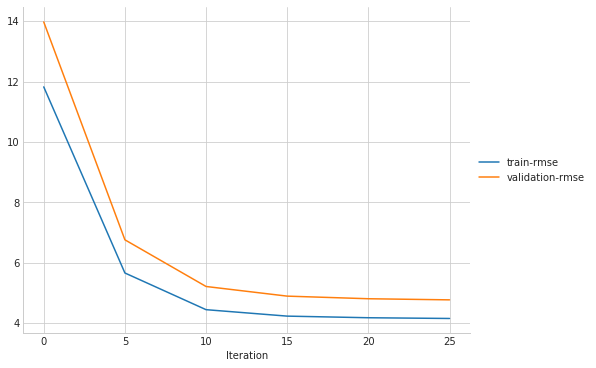

In [48]:
plot_collection(trial, "metrics")

In [49]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(
        trial,
        "feature_importance",
        regex=f"feature_importance/{importance_type}/.*")

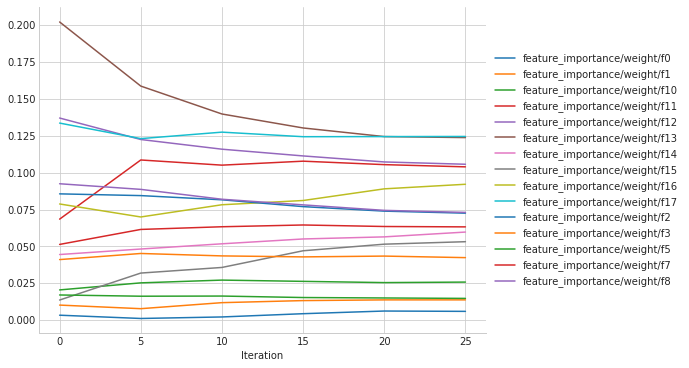

In [50]:
plot_feature_importance(trial)

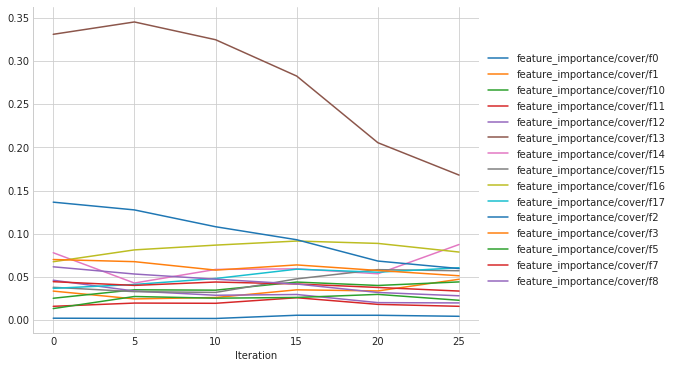

In [51]:
plot_feature_importance(trial, importance_type="cover")

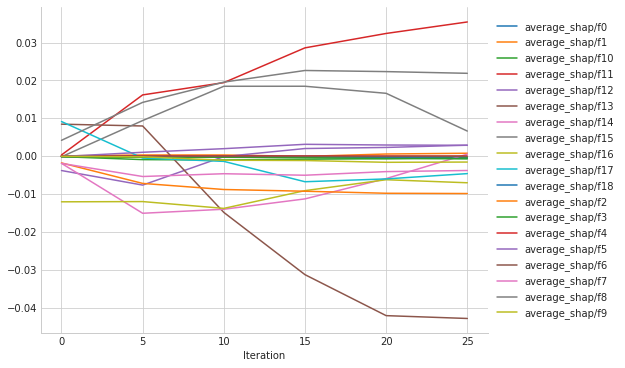

In [52]:
plot_collection(trial,"average_shap")

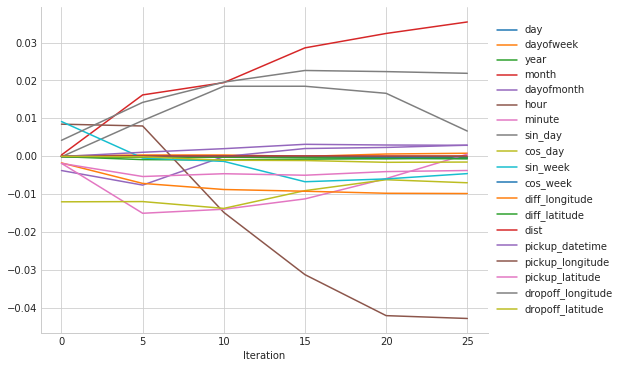

In [53]:
plot_collection_names(trial,"average_shap",feature_names)

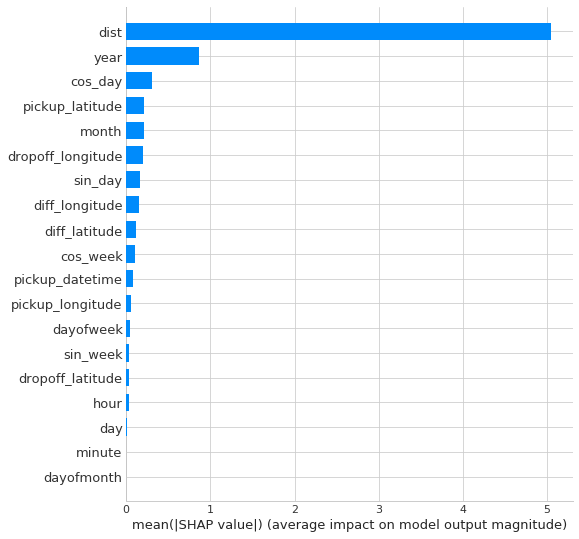

In [54]:
shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type='bar', feature_names=feature_names)

## Deploy the model 

In [ ]:
xgb_predictor = xgboost_estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

---------------

## Evaluate results 

Parts taken from here:<br>
https://aws.amazon.com/blogs/machine-learning/simplify-machine-learning-with-xgboost-and-amazon-sagemaker/

In [67]:
from sagemaker.predictor import csv_serializer

In [68]:
df_test = df_2015

In [69]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(df_test.as_matrix()[:, 1:])
predictions

Method .as_matrix will be removed in a future version. Use .values instead.


array([ 6.75800323, 17.50302124,  7.17652225, ...,  9.35698605,
       11.9045887 , 12.89572716])

In [70]:
df_val = pd.DataFrame()
df_val['prediction'] = predictions
df_val['target'] = df_test['fare_amount']

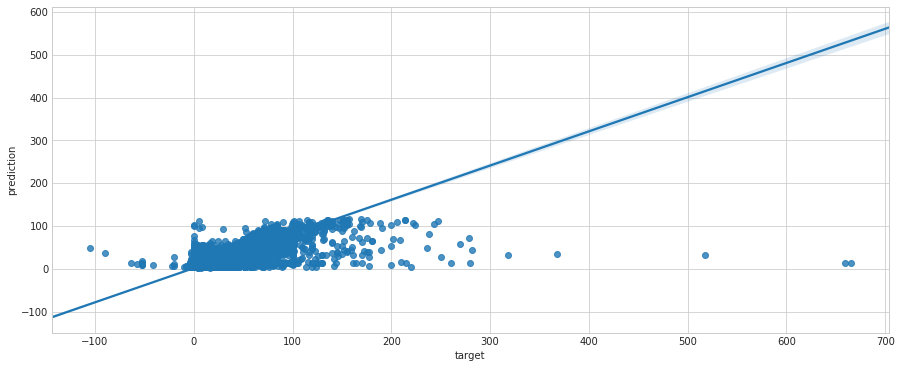

In [71]:
plt.figure(figsize=(15,6))
sns.regplot(x=df_val["target"], y=df_val["prediction"])
plt.show()

In [72]:
df_val['err'] = (df_val["target"] - df_val["prediction"])

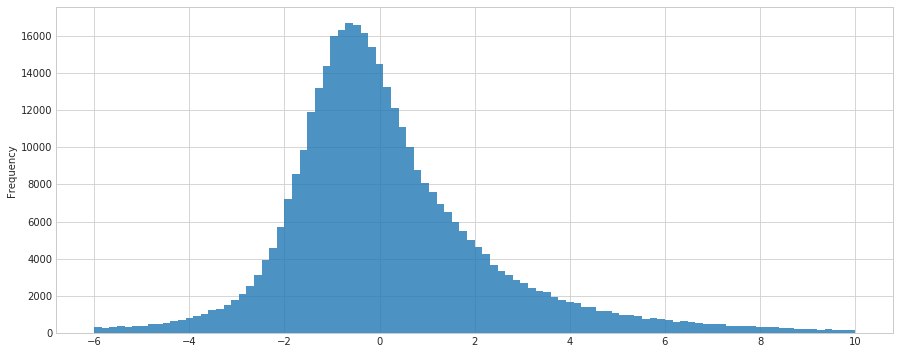

In [73]:
df_val['err'].plot(kind='hist', bins=100, range=(-6,10), alpha=0.8, figsize=(15,6))
plt.show()

In [74]:
df_val.describe()

,prediction,target,err
count,384936.000000,384936.000000,384936.000000
mean,12.608651,12.954483,0.345831
std,10.059393,11.500126,4.745493
min,2.901667,-105.000000,-154.707352
25%,6.922426,6.500000,-1.161783
50%,9.380018,9.500000,-0.204174
75%,13.791102,14.500000,1.177450
max,116.683632,665.230000,651.704382


## Make online predictions

In [75]:
import ast

In [76]:
df = pd.read_csv(s3_path_2015)
del df['pickup_datetime']

n = 50
features = df.iloc[0:n,1:].values
values  = df.iloc[0:n,0].values

In [78]:
endpoint_name = 'sagemaker-xgboost-2020-06-21-13-27-53-616'
content_type = 'text/csv'
data = "\n".join(["\n".join([",".join(str(x) for x in sample)]) for sample in features])

runtime = boto3.Session().client('sagemaker-runtime')
response = runtime.invoke_endpoint(EndpointName=endpoint_name,\
                                   ContentType='text/csv',\
                                   Body=data) 

In [79]:
result = list(ast.literal_eval(response['Body'].read().decode()))
print(result)

[11.376298904418945, 8.838580131530762, 13.788578033447266, 6.279760360717773, 5.272265434265137, 12.905450820922852, 9.531548500061035, 9.273491859436035, 7.028800010681152, 55.181396484375, 6.634429931640625, 17.52536392211914, 12.949896812438965, 7.446811199188232, 7.730220317840576, 13.442258834838867, 35.59539031982422, 11.345636367797852, 29.179561614990234, 8.123872756958008, 37.44322204589844, 8.94620132446289, 8.387168884277344, 9.381961822509766, 12.152754783630371, 4.663315773010254, 7.9676361083984375, 17.96463394165039, 8.234149932861328, 16.201587677001953, 13.252041816711426, 16.404741287231445, 6.758003234863281, 9.945616722106934, 12.125335693359375, 17.503021240234375, 13.375733375549316, 5.857551097869873, 16.297391891479492, 13.912768363952637, 7.176522254943848, 6.552631855010986, 9.05281925201416, 8.400800704956055, 6.646176815032959, 5.2903008460998535, 7.758707046508789, 8.153520584106445, 11.335554122924805, 9.155867576599121]


## Explain the model (Kernel SHAP)

In [80]:
df_sample = df.sample(n=200)

In [81]:
df_sample.columns

Index(['fare_amount', 'day', 'dayofweek', 'year', 'month', 'dayofmonth',
       'hour', 'minute', 'sin_day', 'cos_day', 'sin_week', 'cos_week',
       'diff_longitude', 'diff_latitude', 'dist', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [82]:
df_sample = df_sample.iloc[:, 1:]

In [83]:
explainer = shap.KernelExplainer(predict,df_sample.as_matrix())

Method .as_matrix will be removed in a future version. Use .values instead.
Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [ ]:
shap_values = explainer.shap_values(df_sample.as_matrix(), nsamples=100)

Method .as_matrix will be removed in a future version. Use .values instead.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

In [ ]:
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type='bar', feature_names=feature_names)

In [ ]:
shap.summary_plot(shap_values, df_sample)

In [ ]:
shap.initjs()

In [ ]:
shap.force_plot(shap_base_value, shap_values[90, :], df_sample.iloc[90, :], link="identity", matplotlib=True)

In [ ]:
shap.force_plot(shap_base_value, shap_values[120, :], df_sample.iloc[120, :], link="identity", matplotlib=True)